#### Objective:

The main objective of this study is to build a classifier to predict the drug rating accurately based on the users’ textual reviews.

**Installing required libraries:**

In [3]:
!pip install nlpaug

In [ ]:
!pip install contractions

**Importing required libraries:**

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import contractions
from tqdm import tqdm
import nltk
from nltk.corpus import words
from collections import Counter
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import Normalizer
from wordcloud import WordCloud,STOPWORDS
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import nlpaug
import nlpaug.augmenter.word as naw
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
#nltk.download('stopwords')
#from nltk.corpus import stopwords

#### **Dataset details:**

The dataset contains 215063 instances and 6 attributes.

**Attribute Information:**<br>

1. drugName (categorical): name of drug<br>
2. condition (categorical): name of condition<br>
3. review (text): patient review<br>
4. rating (numerical): 10 star patient rating<br>
5. date (date): date of review entry<br>
6. usefulCount (numerical): number of users who found review useful

https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

In [2]:
#Reading the train and test datasets
df_train = pd.read_csv('drugsComTrain_raw.tsv',sep='\t')

In [3]:
#printing top 5 rows of the train dataset.
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
#checking if there are any null values in each column
df_train.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

It can be observed that the condition column has null values.

In [5]:
print('There are',df_train.shape[0],'records before dropping null values from train data')

There are 161297 records before dropping null values from train data


In [6]:
df_train.dropna(inplace=True)

In [7]:
print('There are',df_train.shape[0],'records remaining after dropping null values from train data')

There are 160398 records remaining after dropping null values from train data


In [8]:
#checking the datatypes of each column
df_train.dtypes

Unnamed: 0       int64
drugName        object
condition       object
review          object
rating         float64
date            object
usefulCount      int64
dtype: object

**Exploratoy Data Analysis:**

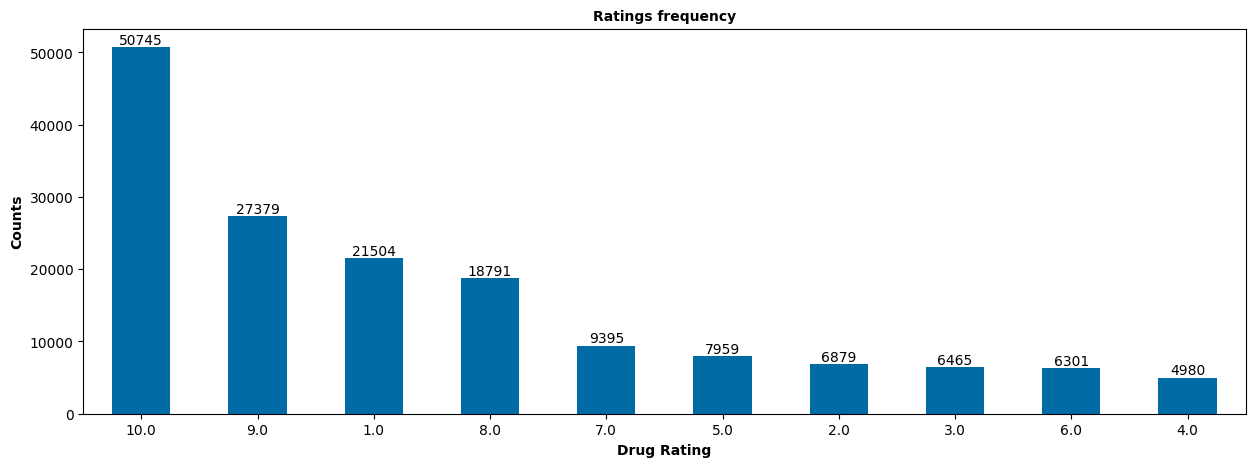

In [9]:
plt.style.use('tableau-colorblind10')
ax = df_train['rating'].value_counts().plot(kind='bar',figsize=(15,5))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
plt.xticks(rotation = 0)
plt.xlabel('Drug Rating',fontweight='bold')
plt.ylabel('Counts',fontweight='bold')
plt.title('Ratings frequency',fontsize=10,fontweight='bold')
plt.grid(False)
plt.show()

**Observations:**<br>
From the above chart it can be observed that <br>
* Count of datapoints with rating-10 are high which are 50745 <br>
* Count of datapoints with rating-4 are less which are 4980.

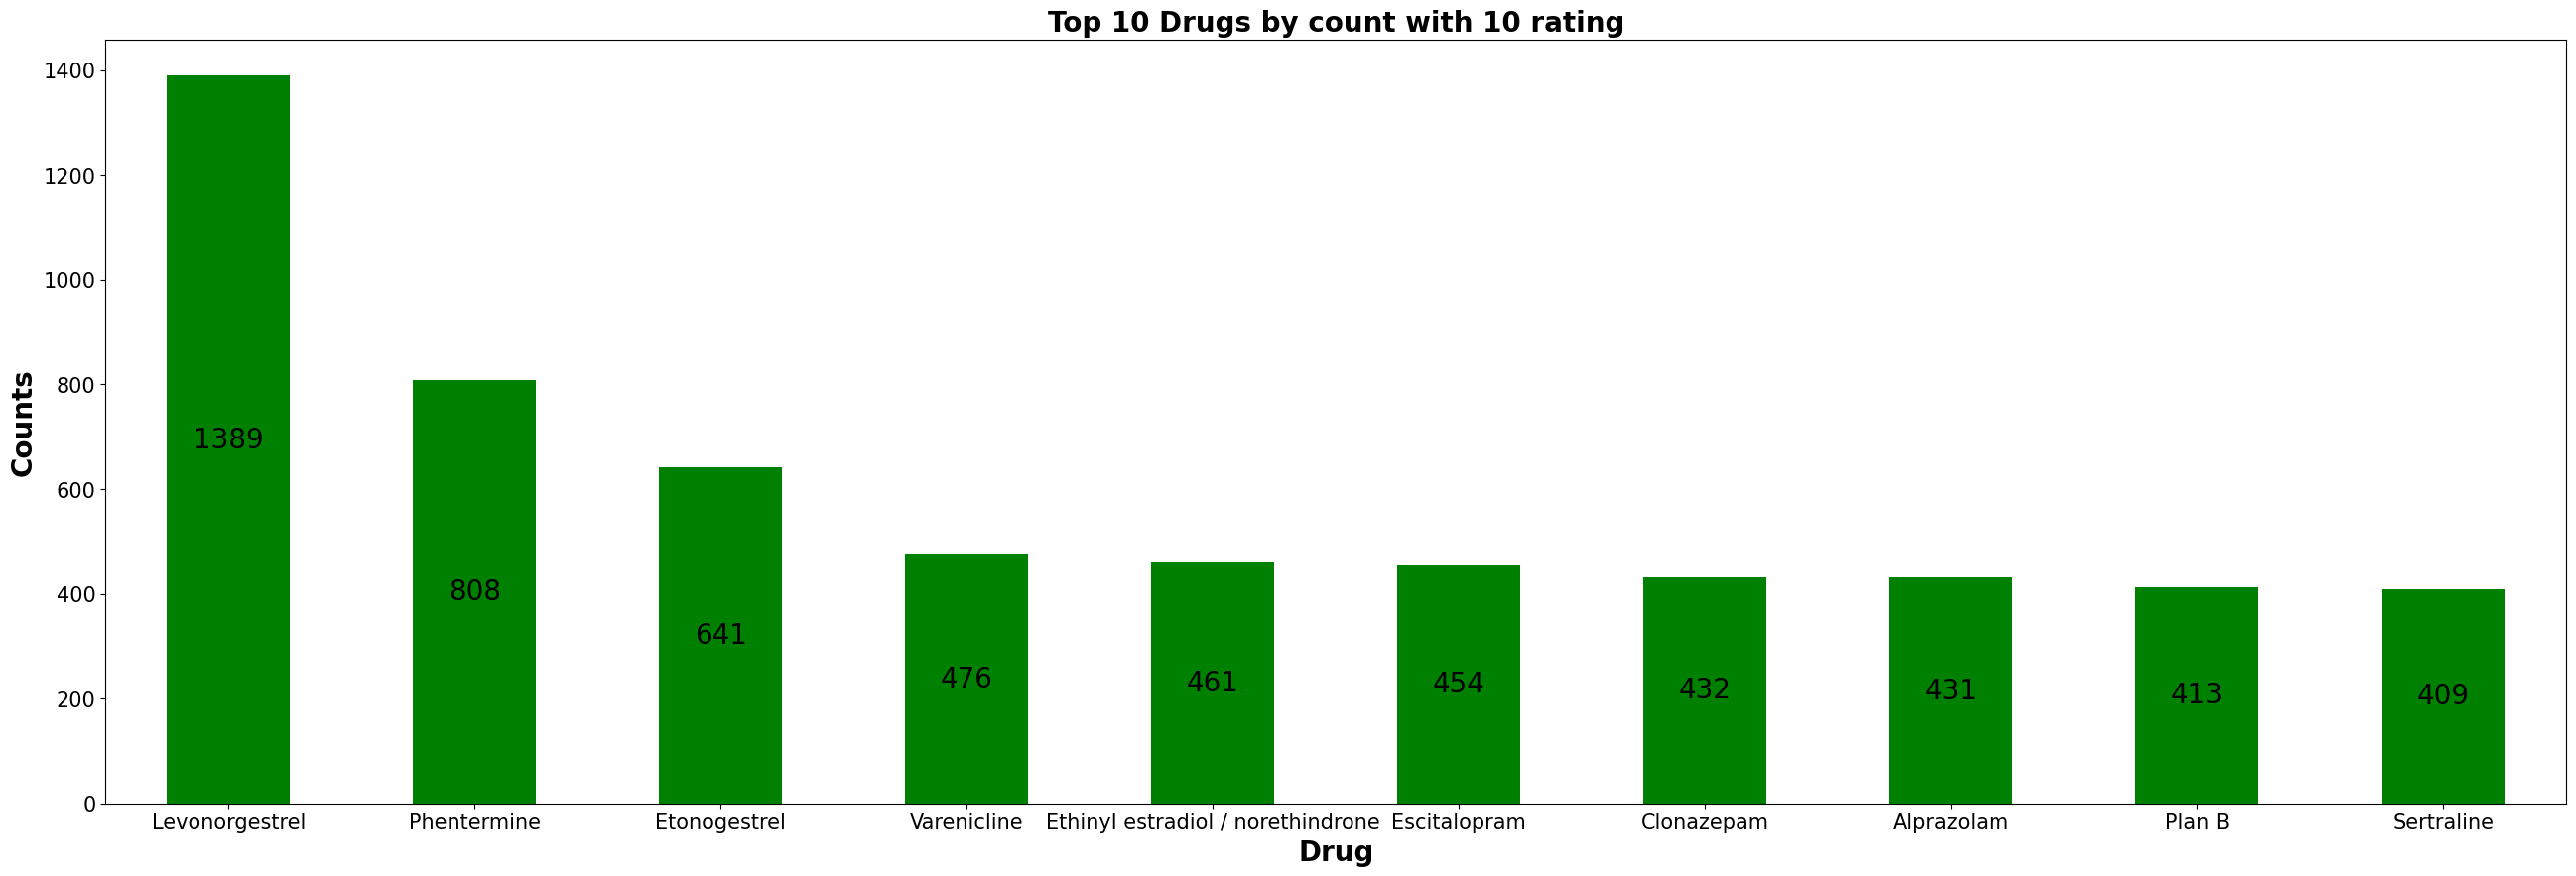

In [10]:
ax = df_train[df_train['rating']==10]['drugName'].value_counts()[:10].plot(kind='bar',figsize=(32,10),color='green')
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center',color='black',fontsize=20)
plt.xticks(rotation = 0,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Drug',fontsize=20,fontweight='bold')
plt.ylabel('Counts',fontsize=20,fontweight='bold')
plt.title('Top 10 Drugs by count with 10 rating',fontsize=20,fontweight='bold')
plt.grid(False)
plt.show()

**Observations:**<br>
From the above chart it can be observed that, among the top 10 drugs by count with 10 rating <br>
* Count of datapoints with Drug-Levonorgestrel are high which are 1389 <br>
* Count of datapoints with Drug-Sertraline are less which are 409.

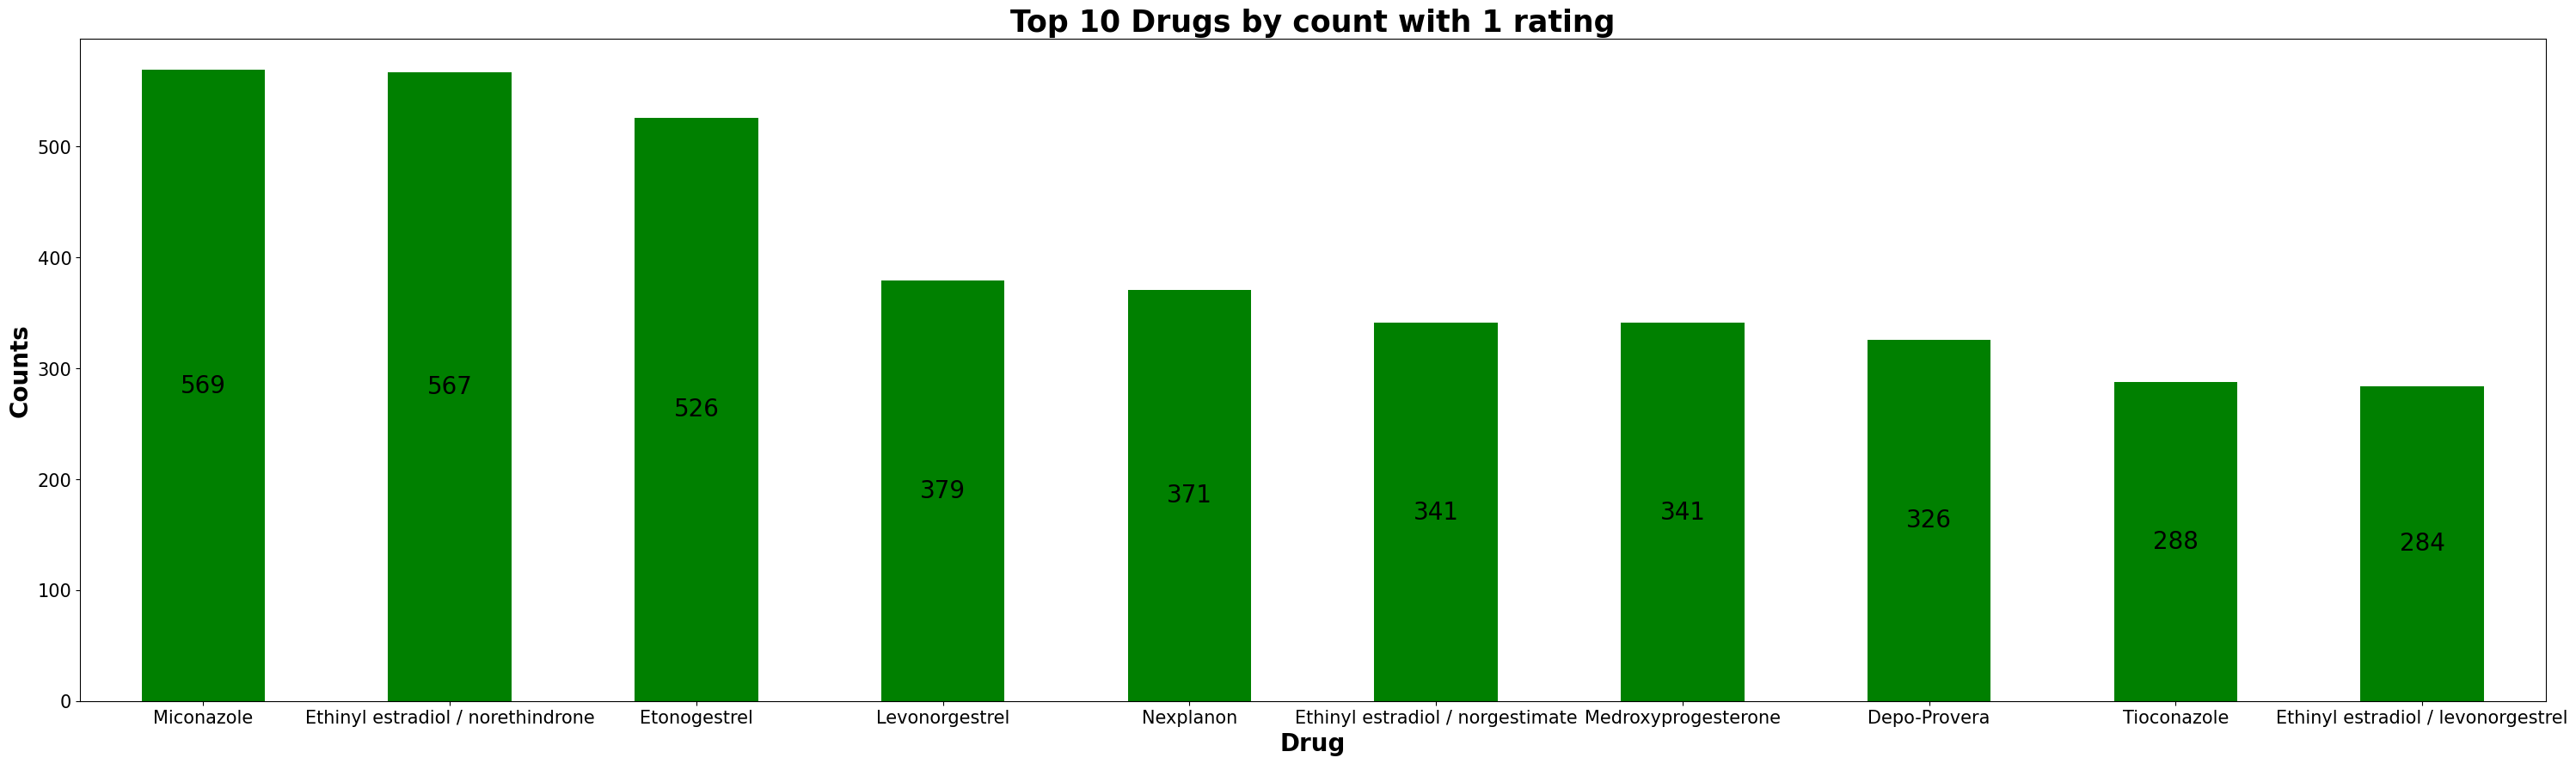

In [11]:
ax = df_train[df_train['rating']==1]['drugName'].value_counts()[:10].plot(kind='bar',figsize=(37,10),color='green')
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center',color='black',fontsize=20)
plt.xticks(rotation = 0,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Drug',fontsize=20,fontweight='bold')
plt.ylabel('Counts',fontsize=20,fontweight='bold')
plt.title('Top 10 Drugs by count with 1 rating',fontsize=25,fontweight='bold')
plt.grid(False)
plt.show()

**Observations:**<br>
From the above chart it can be observed that, among the top 10 drugs by count with 1 rating <br>
* Count of datapoints with Drug-Miconazole are high which are 569 <br>
* Count of datapoints with Drug-Ethinyl estradiol/levonorgestrel are less which are 284.

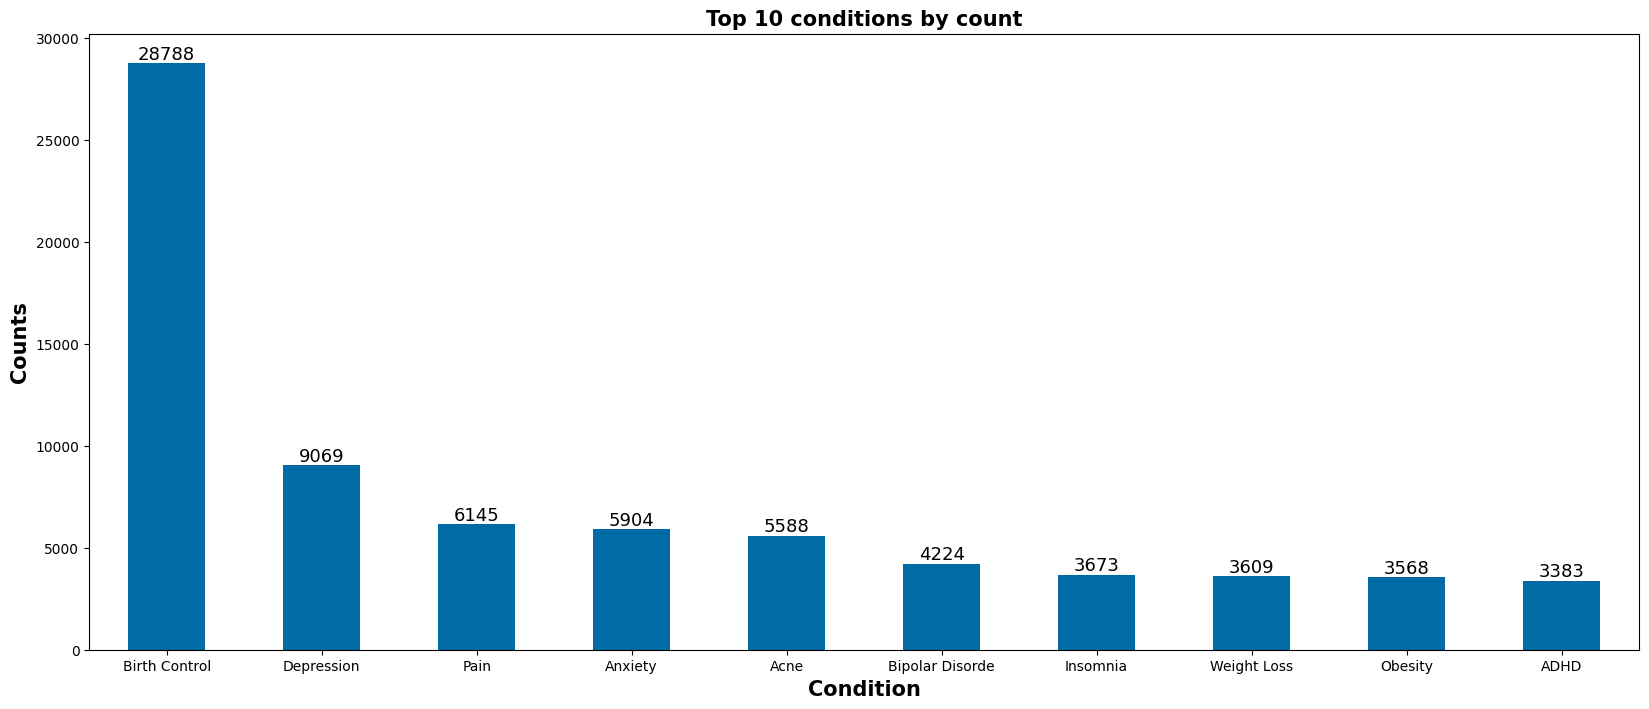

In [12]:
ax = df_train['condition'].value_counts()[:10].plot(kind='bar',figsize=(20,8))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge',fontsize=13)
plt.xticks(rotation = 0)
plt.xlabel('Condition',fontsize=15,fontweight='bold')
plt.ylabel('Counts',fontsize=15,fontweight='bold')
plt.title('Top 10 conditions by count',fontsize=15,fontweight='bold')
plt.grid(False)
plt.show()

**Observations:**<br>
From the above chart it can be observed that, among the top 10 conditions by count <br>
* Count of datapoints with Condition-Birth Control are high which are 28788 <br>
* Count of datapoints with Condition-ADHD are less which are 3383.

In [13]:
#extracting the year from the date column by converting datatype to datatime 
#format and extracting year 
df_train['date'] = pd.to_datetime(df_train['date']).dt.year 

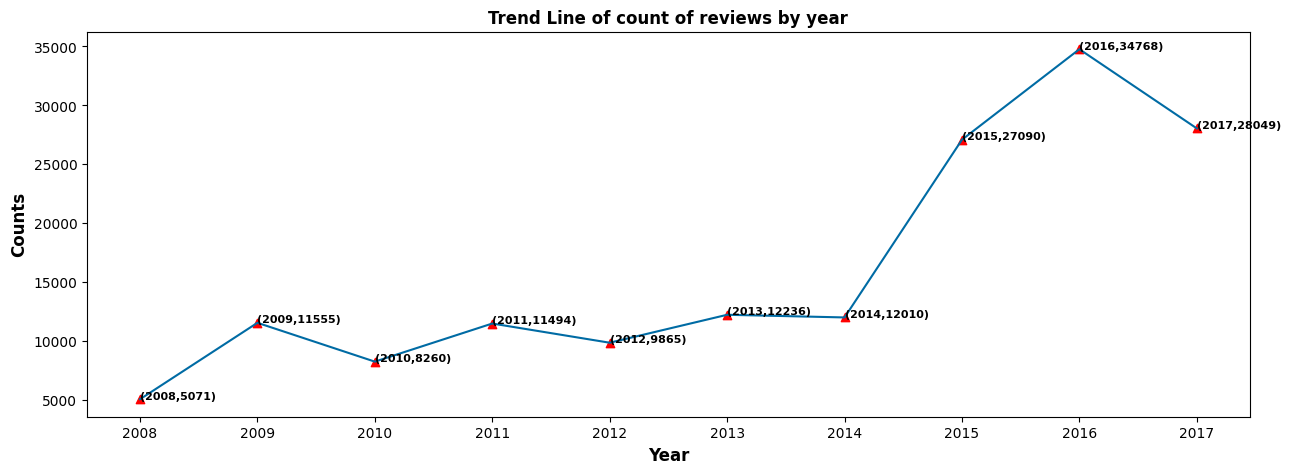

In [14]:
ax = df_train['date'].value_counts().sort_index().plot(kind='line',figsize=(15,5))
plt.xticks(df_train['date'].unique());
labels = df_train['date'].value_counts().sort_index().to_dict()
for i,j in labels.items():
    plt.text(i,j,'({0},{1})'.format(i,j),fontsize=8,color='black',fontweight='bold',horizontalalignment='left')
    plt.scatter(i,j,marker='^',color='red')
plt.xlabel('Year',fontsize=12,fontweight='bold')
plt.ylabel('Counts',fontsize=12,fontweight='bold')
plt.title('Trend Line of count of reviews by year',fontsize=12,fontweight='bold')
plt.grid(False)
plt.show()    

**Observations:**<br>
From the above chart it can be observed that, <br>
* Year 2016 has got highest number of reviews which are 34768. <br>
* Year 2008 has got lowest number of reviews which are 5071.<br>
* Also, there has been steep increase in the number of reviews from 2014 to 2015.<br>
* There has been negligible change in the number of review from 2013 to 2014.

**Text Processing:**

In [15]:
#This function takes text as input processes it 
#and returns the cleaned text.

def text_processing(text):
    
    text = text.replace('"','')
    text = text.replace('&#039;',"'")
    text = contractions.fix(text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = re.sub(' +',' ',text) # remove double or more spaces
    text = text.strip()
    text = text.lower()
    stop_words = open('stoplist.txt','r').read().split('\n')
    text = ' '.join([j for j in text.split(' ') if j not in stop_words]) #removing stop words
    text = ' '.join([j for j in text.split(' ') if len(j)>1]) #removing words of length 1
    
    return text   

In [16]:
#creating a copy of train data.
processed_data = df_train.copy()

In [17]:
#dropping the Unnamed: 0 and date columns considering it has no significance.
processed_data.drop(['Unnamed: 0','date'],axis=1,inplace=True)

In [18]:
#cleaning the text in review column using text_processing function
tqdm.pandas()
processed_data['review'] = processed_data['review'].progress_apply(lambda x: text_processing(x))

100%|████████████████████████████████████████████████████████████████████████| 160398/160398 [02:03<00:00, 1297.78it/s]


In [19]:
#storing the cleaned data in pickle file 
processed_data.to_pickle("processed_data.pkl")  

In [20]:
#loading the pickle file.
processed_data = pd.read_pickle('processed_data.pkl')

In [21]:
#converting the datatype of rating column to int
processed_data['rating'] = processed_data.rating.astype('int32')

In [22]:
#Here we have some empty strings in the review column.
#These rows must be removed by using the indices
#indices whose text length in the review column is 0
list_zero_text_len = processed_data[processed_data['review'].str.len().sort_values()==0].index.to_list()

In [23]:
#dropping all the indices whose text length in the review column is 0
processed_data.drop(list_zero_text_len,inplace=True)

In [24]:
#This function converts rating values (1-10) 
#to labels ('positive','negative','neutral')

def rating_class(x):
    if x>8:
        return 'positive'
    elif x<3:
        return 'negative'
    else:
        return 'neutral'

In [25]:
#converts the values in the rating column using the rating_class function.
tqdm.pandas()
processed_data['rating'] = processed_data['rating'].progress_apply(lambda x:rating_class(x)) 

100%|██████████████████████████████████████████████████████████████████████| 159790/159790 [00:00<00:00, 937568.67it/s]


In [26]:
#encoding the rating column
le = preprocessing.LabelEncoder().fit(processed_data['rating'].values)

In [27]:
processed_data['rating'] = le.transform(processed_data['rating'].values)

In [28]:
processed_data['rating'].value_counts()

2    77708
1    53771
0    28311
Name: rating, dtype: int64

From the above counts of rating values, it can be observed that the data is not perfectly balanced.

In [29]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [37]:
#here 77708-53771 is the imbalance of label 1 with respect to label 2.
#here 77708-28311 is the imbalance of label 0 with respect to label 2.

low_counts = [(1,77708-53771),(0,77708-28311)]

In [38]:
#Here over sampling is used in order to handle class imbalance
#While over sampling text data is augmented using nlpaug

import random
new_data = []
aug = naw.SynonymAug(aug_src='wordnet',aug_p=0.7)
for i in tqdm(low_counts):
    a = processed_data[processed_data['rating']==i[0]].reset_index()
    for j in range(i[1]):
        r = random.randint(0,len(a)-1)
        aug_text = aug.augment(a['review'].tolist()[r],n=1)
        df_list = a.iloc[r,:].to_frame().loc[['drugName','condition','rating','usefulCount'],:].\
                             values.flatten().tolist() + aug_text
        new_data.append(tuple(df_list))

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:04<00:00, 182.11s/it]


In [39]:
#creating the dataframe for the augmneted texts
new_dataframe = pd.DataFrame(new_data,columns=['drugName','condition','rating','usefulCount','review'])

In [40]:
second_column = new_dataframe.pop('review')

In [41]:
#processed_data dataframe contains review column at index 2 position
#changing the review column position as per the processed_data dataframe.

new_dataframe.insert(2, 'review', second_column)

In [42]:
#concatenating the new dataframe and processed dataframe which creates
#the balanced dataset.

augmented_data = pd.concat([processed_data,new_dataframe],ignore_index=True)

In [43]:
#Class labels after over sampling the dataset.
augmented_data['rating'].value_counts()

2    77708
1    77708
0    77708
Name: rating, dtype: int64

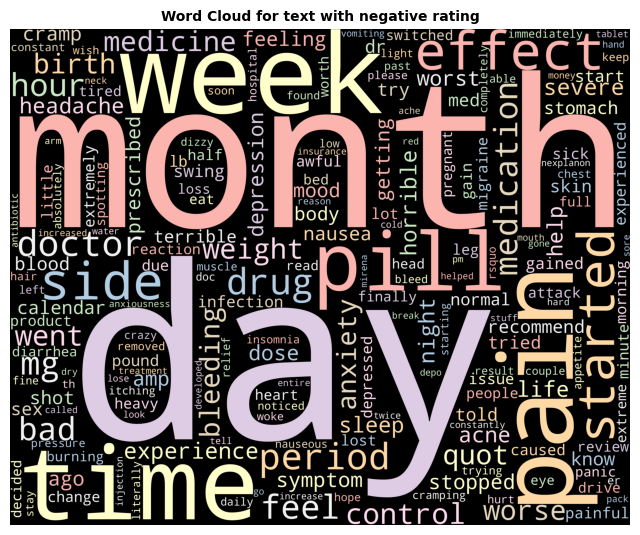

In [44]:
text_data = ' '.join(i for i in augmented_data[augmented_data['rating']==0]['review'])

# Generate word cloud from review text
plt.figure(figsize=(8,8))
word_cloud = WordCloud(
        width=5000,
        height=4000,
        random_state=1,
        background_color="black",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text_data)
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Word Cloud for text with negative rating',fontsize=10,fontweight='bold')
plt.show()

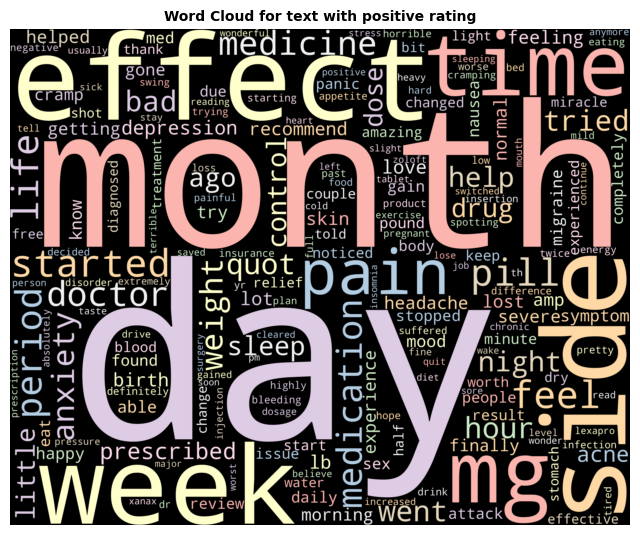

In [45]:
text_data = ' '.join(i for i in augmented_data[augmented_data['rating']==2]['review'])

plt.figure(figsize=(8,8))
word_cloud = WordCloud(
        width=5000,
        height=4000,
        random_state=1,
        background_color="black",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS, 
        ).generate(text_data)
plt.imshow(word_cloud,interpolation='bilinear')
plt.title('Word Cloud for text with positive rating',fontsize=10,fontweight='bold')
plt.axis('off')
plt.show()

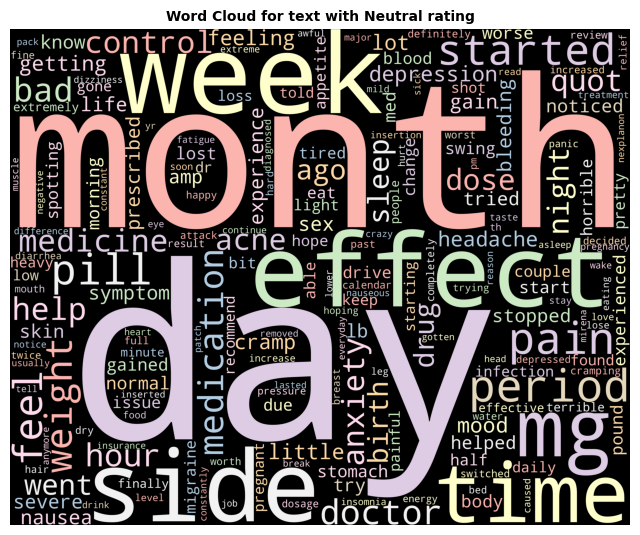

In [46]:
text_data = ' '.join(i for i in augmented_data[augmented_data['rating']==1]['review'])

# Generate word cloud from review text
plt.figure(figsize=(8,8))
word_cloud = WordCloud(
        width=5000,
        height=4000,
        random_state=1,
        background_color="black",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text_data)
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Word Cloud for text with Neutral rating',fontsize=10,fontweight='bold')
plt.show()

**Feature Engineering:**

Here word count feature is engineered using number of words of each text in the review column.

In [47]:
augmented_data['word_count'] = augmented_data['review'].str.split().apply(len)

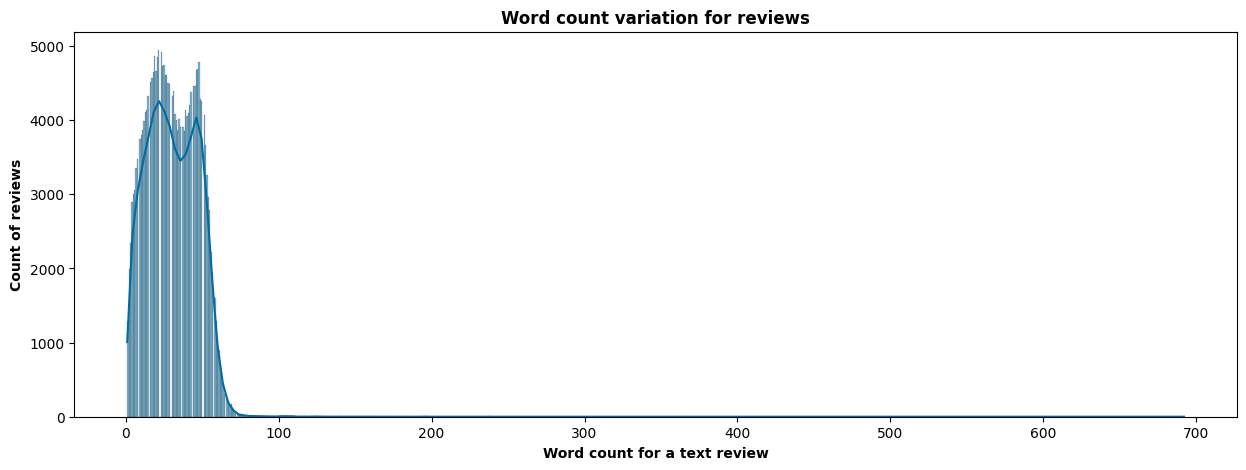

In [48]:
plt.figure(figsize=(15,5))
sns.histplot(data=augmented_data,x='word_count',kde=True)
plt.xlabel('Word count for a text review',fontweight='bold')
plt.ylabel('Count of reviews',fontweight='bold')
plt.title('Word count variation for reviews',fontweight='bold')
plt.show()

**Observations:**<br>
* It can be observed that the distribution of word count of review column is skewed and is skewed to right.    

**Train-CV Split:**

In [49]:
y = augmented_data.rating.values
X = augmented_data.drop(['rating'],axis=1)

In [50]:
X_train,X_cv,y_train,y_cv = train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)

**Vectorization:**

**Vectorizing Review column using Bag of Words:**

In [52]:
# Encoding review column using BOW
from sklearn.feature_extraction.text import CountVectorizer

print('Before Vectorization of review column using BOW')

print(X_train['review'].shape)
print(X_cv['review'].shape)

print("="*100)
#fit has to happen only on train data
vector_bow_review  = CountVectorizer(min_df=10, ngram_range=(1,4),max_features=100).fit(X_train['review'].values)

X_train_bow_review = vector_bow_review.transform(X_train['review'].values)
X_cv_bow_review    = vector_bow_review.transform(X_cv['review'].values)

print('After Vectorization of review column using BOW')

print(X_train_bow_review.shape)
print(X_cv_bow_review.shape)

Before Vectorization of review column using BOW
(163186,)
(69938,)
After Vectorization of review column using BOW
(163186, 100)
(69938, 100)


**Vectorizing Review column using TFIDF:**

In [53]:
# Encoding review column using TFIDF
print('Before Vectorization of review column using TFIDF')

print(X_train['review'].shape)
print(X_cv['review'].shape)

print("="*100)
#fit has to happen only on train data
vector_tfidf_review  = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=100).fit(X_train['review'].values)

X_train_tfidf_review = vector_tfidf_review.transform(X_train['review'].values)
X_cv_tfidf_review    = vector_tfidf_review.transform(X_cv['review'].values)

print('After Vectorization of review column using TFIDF')

print(X_train_tfidf_review.shape)
print(X_cv_tfidf_review.shape)

Before Vectorization of review column using TFIDF
(163186,)
(69938,)
After Vectorization of review column using TFIDF
(163186, 100)
(69938, 100)


**Vectorizing Review column using TFIDF Word2Vec:**

In [54]:
import pickle
with open('glove.840B.300d.pkl', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [55]:
# fitting the model on train data
vector_tfidfw2v_review = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=100).fit(X_train['review'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vector_tfidfw2v_review.get_feature_names_out(), list(vector_tfidfw2v_review.idf_)))
tfidf_words = set(vector_tfidfw2v_review.get_feature_names_out())

In [56]:
X_train_tfidfw2v_review = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['review'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) 
            #and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidfw2v_review.append(vector)
X_train_tfidfw2v_review = np.array(X_train_tfidfw2v_review)
print(X_train_tfidfw2v_review.shape)

100%|████████████████████████████████████████████████████████████████████████| 163186/163186 [00:29<00:00, 5530.53it/s]


(163186, 300)


In [57]:
X_cv_tfidfw2v_review = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['review'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) 
            #and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_tfidfw2v_review.append(vector)
X_cv_tfidfw2v_review = np.array(X_cv_tfidfw2v_review)
print(X_cv_tfidfw2v_review.shape)

100%|██████████████████████████████████████████████████████████████████████████| 69938/69938 [00:10<00:00, 6520.98it/s]


(69938, 300)


**Vectorizing Condition column using Bag of Words:**

In [60]:
#encoding the categorical column 'condition' using BOW
print('Before Vectorization of condition column using BOW')

print(X_train['condition'].shape)
print(X_cv['condition'].shape)

print("="*100)

# fit has to happen only on train data
vector_bow_condition     = CountVectorizer(min_df=5,max_features=100).fit(X_train['condition'].values)

X_train_bow_condition    = vector_bow_condition.transform(X_train['condition'].values)
X_cv_bow_condition       = vector_bow_condition.transform(X_cv['condition'].values)          

print('After Vectorization of condition column using BOW')

print(X_train_bow_condition.shape)
print(X_cv_bow_condition.shape)

Before Vectorization of condition column using BOW
(163186,)
(69938,)
After Vectorization of condition column using BOW
(163186, 100)
(69938, 100)


**Vectorizing DrugName column using Bag of Words:**

In [61]:
#encoding the categorical column 'drugname' using BOW
print('Before Vectorization of drugName column using BOW')

print(X_train['drugName'].shape)
print(X_cv['drugName'].shape)

print("="*100)

# fit has to happen only on train data
vector_bow_drugName    = CountVectorizer(min_df=5,max_features=100).fit(X_train['drugName'].values)

X_train_bow_drugName   = vector_bow_drugName.transform(X_train['drugName'].values)
X_cv_bow_drugName      = vector_bow_drugName.transform(X_cv['drugName'].values)  

print('After Vectorization of drugName column using BOW')

print(X_train_bow_drugName.shape)
print(X_cv_bow_drugName.shape)

Before Vectorization of drugName column using BOW
(163186,)
(69938,)
After Vectorization of drugName column using BOW
(163186, 100)
(69938, 100)


**Scaling WordCount and UsefulCount columns using Normalizer:**

In [62]:
#Normalizing the numerical column 'usefulcount' and 'word count' using Normalizer
from sklearn.preprocessing import Normalizer

print('Before normalizing of usefulCount column using Normalizer')

print(X_train[['usefulCount','word_count']].shape)
print(X_cv[['usefulCount','word_count']].shape)

print("="*100)
# fit has to happen only on train data
norm_count = Normalizer().fit(X_train[['usefulCount','word_count']].values)

X_train_norm_count    = norm_count.transform(X_train[['usefulCount','word_count']].values)
X_cv_norm_count       = norm_count.transform(X_cv[['usefulCount','word_count']].values)

print('After normalizing of usefulCount column using Normalizer')

print(X_train_norm_count.shape)
print(X_cv_norm_count.shape)

Before normalizing of usefulCount column using Normalizer
(163186, 2)
(69938, 2)
After normalizing of usefulCount column using Normalizer
(163186, 2)
(69938, 2)


**Joining all Scaled and Vectorized feautures:**

**Dataset 1:**

Here the dataset 1 uses bow features of review, condition and drugname columns and, normalized features of wordcount and usefulcount columns.

In [63]:
from scipy.sparse import hstack

In [64]:
X_train_1 = hstack((X_train_bow_review,X_train_bow_condition,X_train_bow_drugName,X_train_norm_count)).tocsr()
X_cv_1    = hstack((X_cv_bow_review,X_cv_bow_condition,X_cv_bow_drugName,X_cv_norm_count)).tocsr()

print('Final shape of the Dataset 1')
print(X_train_1.shape, y_train.shape)
print(X_cv_1.shape, y_cv.shape)

Final shape of the Dataset 1
(163186, 302) (163186,)
(69938, 302) (69938,)


**Dataset 2:**

Here the dataset 2 uses tfidf features of review column, bow features of condition and drugname columns and, normalized features of wordcount and usefulcount columns.

In [65]:
X_train_2 = hstack((X_train_tfidf_review,X_train_bow_condition,X_train_bow_drugName,X_train_norm_count)).tocsr()
X_cv_2    = hstack((X_cv_tfidf_review,X_cv_bow_condition,X_cv_bow_drugName,X_cv_norm_count)).tocsr()

print('Final shape of the Dataset 2')
print(X_train_2.shape, y_train.shape)
print(X_cv_2.shape, y_cv.shape)

Final shape of the Dataset 2
(163186, 302) (163186,)
(69938, 302) (69938,)


**Dataset 3:**

Here the dataset 3 uses tfidf-word2vec features of review column, bow features of condition and drugname columns and, normalized features of wordcount and usefulcount columns.

In [66]:
X_train_3 = hstack((X_train_tfidfw2v_review,X_train_bow_condition,X_train_bow_drugName,X_train_norm_count)).tocsr()
X_cv_3    = hstack((X_cv_tfidfw2v_review,X_cv_bow_condition,X_cv_bow_drugName,X_cv_norm_count)).tocsr()

print('Final shape of the Dataset 3')
print(X_train_3.shape, y_train.shape)
print(X_cv_3.shape, y_cv.shape)

Final shape of the Dataset 3
(163186, 502) (163186,)
(69938, 502) (69938,)


In [67]:
#This function prints accuracy score for train and cross-validation datasets

def metric_score(model,x_train,x_cv,y_train,y_cv):
    
    y_train_pred = model.predict(x_train)
    y_cv_pred    = model.predict(x_cv)
    
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_cv    = accuracy_score(y_cv, y_cv_pred)
    
    print('Train Accuracy Score is',acc_train)
    print('CV Accuracy Score is',acc_cv)

    return None 

Note - Here accuracy has been used as the performance metric since the dataset has been made balanced.

**Hyperparameter Tuning:**

* Here, hyperparameter tuning has been done using RandomSearch Cross Validation since it is computationally less expensive than Grid Search Cross Validation.<br> 
* Also, here for tuning 2-fold cross validation splitting strategy and 4 iterations has been used.

**Random Forest Classifier for Dataset 1:**

In [68]:
rf_clf  = RandomForestClassifier()
params  = {'max_depth'        : [2,5,7,9,11],
           'n_estimators'     : [5,50,100,200,500]
          }
random_rf = RandomizedSearchCV(rf_clf,param_distributions=params,verbose=2,cv=2,n_iter=3).fit(
                               X_train_1,y_train)    
RF_1      = rf_clf.set_params(**random_rf.best_params_).fit(X_train_1,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .......................max_depth=9, n_estimators=50; total time=   9.7s
[CV] END .......................max_depth=9, n_estimators=50; total time=   4.3s
[CV] END .......................max_depth=7, n_estimators=50; total time=   2.5s
[CV] END .......................max_depth=7, n_estimators=50; total time=   2.9s
[CV] END ......................max_depth=11, n_estimators=50; total time=   6.3s
[CV] END ......................max_depth=11, n_estimators=50; total time=   6.3s


In [69]:
#prints accuracy score for train and cv datasets
metric_score(RF_1,X_train_1,X_cv_1,y_train,y_cv)

Train Accuracy Score is 0.5527863909894231
CV Accuracy Score is 0.5324859160971146


**XGBoost Classifier for Dataset 1:**

In [70]:
xgb_clf    = XGBClassifier()
params     = {'n_estimators'    : [5,50,100,150,200,300],
              'max_depth'       : [3,5,7,9],
              'colsample_bytree': [0.2,0.3,0.4,0.5]
             }       
random_xgb = RandomizedSearchCV(xgb_clf,param_distributions=params,verbose=2,cv=2,n_iter=3).fit(
                                X_train_1,y_train)     
XGB_1      = xgb_clf.set_params(**random_xgb.best_params_).fit(X_train_1,y_train)    

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..colsample_bytree=0.2, max_depth=5, n_estimators=5; total time=  15.4s
[CV] END ..colsample_bytree=0.2, max_depth=5, n_estimators=5; total time=   0.4s
[CV] END colsample_bytree=0.4, max_depth=5, n_estimators=150; total time=  14.0s
[CV] END colsample_bytree=0.4, max_depth=5, n_estimators=150; total time=  11.2s
[CV] END ..colsample_bytree=0.4, max_depth=7, n_estimators=5; total time=   1.7s
[CV] END ..colsample_bytree=0.4, max_depth=7, n_estimators=5; total time=   0.7s


In [71]:
#prints accuracy score for train and cv datasets
metric_score(XGB_1,X_train_1,X_cv_1,y_train,y_cv)

Train Accuracy Score is 0.6297231380142905
CV Accuracy Score is 0.594555177442878


**Random Forest Classifier for Dataset 2:**

In [72]:
rf_clf  = RandomForestClassifier()
params  = {'max_depth'        : [2,5,7,9,11],
           'n_estimators'     : [5,50,100,200,500]
          }
random_rf    = RandomizedSearchCV(rf_clf,param_distributions=params,verbose=2,cv=2,n_iter=3).fit(X_train_2,y_train)    
RF_2         = rf_clf.set_params(**random_rf.best_params_).fit(X_train_2,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ......................max_depth=5, n_estimators=200; total time=  11.0s
[CV] END ......................max_depth=5, n_estimators=200; total time=   9.3s
[CV] END ......................max_depth=11, n_estimators=50; total time=   6.9s
[CV] END ......................max_depth=11, n_estimators=50; total time=   6.8s
[CV] END ......................max_depth=2, n_estimators=200; total time=   5.6s
[CV] END ......................max_depth=2, n_estimators=200; total time=   5.3s


In [73]:
#prints accuracy score for train and cv datasets
metric_score(RF_2,X_train_2,X_cv_2,y_train,y_cv)

Train Accuracy Score is 0.5542019535989607
CV Accuracy Score is 0.5330006577254139


**XGBoost Classifier for Dataset 2:**

In [74]:
xgb_clf = XGBClassifier()
params  = {'n_estimators'    : [5,50,100,150,200,300],
              'max_depth'       : [3,5,7,9],
              'colsample_bytree': [0.2,0.3,0.4,0.5]
             }       
random_xgb = RandomizedSearchCV(xgb_clf,param_distributions=params,verbose=2,cv=2,n_iter=3).fit(X_train_2,y_train)     
XGB_2      = xgb_clf.set_params(**random_xgb.best_params_).fit(X_train_2,y_train)    

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END colsample_bytree=0.5, max_depth=9, n_estimators=200; total time= 1.7min
[CV] END colsample_bytree=0.5, max_depth=9, n_estimators=200; total time= 1.6min
[CV] END colsample_bytree=0.3, max_depth=7, n_estimators=300; total time= 1.3min
[CV] END colsample_bytree=0.3, max_depth=7, n_estimators=300; total time= 1.3min
[CV] END colsample_bytree=0.3, max_depth=9, n_estimators=150; total time=  46.3s
[CV] END colsample_bytree=0.3, max_depth=9, n_estimators=150; total time=  46.1s


In [75]:
#prints accuracy score for train and cv datasets
metric_score(XGB_2,X_train_2,X_cv_2,y_train,y_cv)

Train Accuracy Score is 0.8127535450345005
CV Accuracy Score is 0.66474591781292


**Random Forest Classifier for Dataset 3:**

In [76]:
rf_clf  = RandomForestClassifier()
params  = {'max_depth'        : [2,5,7,9,11],
           'n_estimators'     : [5,50,100,200,500]
          }
random_rf = RandomizedSearchCV(rf_clf,param_distributions=params,verbose=2,cv=2,n_iter=3).fit(
                               X_train_3,y_train)    
RF_3      = rf_clf.set_params(**random_rf.best_params_).fit(X_train_3,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ......................max_depth=7, n_estimators=500; total time=11.0min
[CV] END ......................max_depth=7, n_estimators=500; total time=11.0min
[CV] END ........................max_depth=7, n_estimators=5; total time=   8.3s
[CV] END ........................max_depth=7, n_estimators=5; total time=   7.8s
[CV] END ......................max_depth=5, n_estimators=100; total time= 1.4min
[CV] END ......................max_depth=5, n_estimators=100; total time= 1.4min


In [77]:
#prints accuracy score for train and cv datasets
metric_score(RF_3,X_train_3,X_cv_3,y_train,y_cv)

Train Accuracy Score is 0.5193521503070117
CV Accuracy Score is 0.5050616260116103


**XGBoost Classifier for Dataset 3:**

In [78]:
xgb_clf = XGBClassifier()
params  =   {'n_estimators'    : [5,50,100,150,200,300],
              'max_depth'       : [3,5,7,9],
              'colsample_bytree': [0.2,0.3,0.4,0.5]
             }       
random_xgb = RandomizedSearchCV(xgb_clf,param_distributions=params,verbose=2,cv=2,n_iter=3).fit(X_train_3,y_train)     
XGB_3      = xgb_clf.set_params(**random_xgb.best_params_).fit(X_train_3,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .colsample_bytree=0.4, max_depth=5, n_estimators=50; total time= 4.9min
[CV] END .colsample_bytree=0.4, max_depth=5, n_estimators=50; total time= 5.1min
[CV] END ..colsample_bytree=0.4, max_depth=9, n_estimators=5; total time= 1.0min
[CV] END ..colsample_bytree=0.4, max_depth=9, n_estimators=5; total time= 1.0min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=150; total time=22.0min
[CV] END colsample_bytree=0.4, max_depth=7, n_estimators=150; total time=23.6min


In [79]:
#prints accuracy score for train and cv datasets.
metric_score(XGB_3,X_train_3,X_cv_3,y_train,y_cv)

Train Accuracy Score is 0.8101307710220239
CV Accuracy Score is 0.6313735022448455


**Predictions on test data:**

In [80]:
df_test  = pd.read_csv('drugsComTest_raw.tsv',sep='\t')

In [81]:
df_test['review'] = df_test['review'].progress_apply(lambda x: text_processing(x))

100%|██████████████████████████████████████████████████████████████████████████| 53766/53766 [00:46<00:00, 1148.14it/s]


In [83]:
df_test.drop(['Unnamed: 0','date'],axis=1,inplace=True)

In [85]:
df_test['word_count'] = df_test['review'].str.split().apply(len)

In [86]:
#BOW Features for the review text column
X_test_bow_review    = vector_bow_review.transform(df_test['review'].values)

In [87]:
#TFIDF Features for the review text column
X_test_tfidf_review    = vector_tfidf_review.transform(df_test['review'].values)

In [88]:
#avg tfidf-word2vec features of review text column

X_test_tfidfw2v_review = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(df_test['review'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) 
            #and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidfw2v_review.append(vector)
X_test_tfidfw2v_review = np.array(X_test_tfidfw2v_review)

100%|███████████████████████████████████████████████████████████████████████████| 53766/53766 [01:21<00:00, 658.27it/s]


In [90]:
#BOW features for the condition column in the test data.
X_test_bow_condition       = vector_bow_condition.transform(df_test['condition'].values.astype('U'))

In [91]:
#BOW features for the drugname column in the test data.
X_test_bow_drugName      = vector_bow_drugName.transform(df_test['drugName'].values)  

In [92]:
#scaling the useful count and word count features in the test data.
X_test_norm_count       = norm_count.transform(df_test[['usefulCount','word_count']].values)

In [93]:
#stacking horizontally bow features of review, condition and drugname columns and 
#scaled features of word count and useful count features to form the test dataset 1
X_test_1  = hstack((X_test_bow_review,X_test_bow_condition,X_test_bow_drugName,X_test_norm_count)).tocsr()

In [94]:
#stacking horizontally tfidf features of review, bow features of condition and drugname columns and 
#scaled features of word count and useful count features to form the test dataset 2
X_test_2  = hstack((X_test_tfidf_review,X_test_bow_condition,X_test_bow_drugName,X_test_norm_count)).tocsr()

In [95]:
#stacking horizontally tfidf-word2vec features of review, bow features of condition and drugname columns and 
#scaled features of word count and useful count features to form the test dataset 3
X_test_3  = hstack((X_test_tfidfw2v_review,X_test_bow_condition,X_test_bow_drugName,X_test_norm_count)).tocsr()

In [99]:
#applying the rating class function for the rating column in the test data
#which maps the ratings to postive negative and neutral values.
tqdm.pandas()
df_test['rating'] = df_test['rating'].progress_apply(lambda x:rating_class(x)) 

100%|████████████████████████████████████████████████████████████████████████| 53766/53766 [00:00<00:00, 471921.41it/s]


In [100]:
#encoding the string labels in the rating column using label encoder.
df_test['rating'] = le.transform(df_test['rating'].values)

In [103]:
y_test = df_test['rating'].values.tolist()

In [104]:
#predictions on test dataset 1 using trained random classifier on train dataset 1.
RF1_test_preds = RF_1.predict(X_test_1)
accuracy_score(y_test,RF1_test_preds)

0.521351783655098

In [105]:
#predictions on test dataset 1 using trained xgboost classifier on train dataset 1.
XGB1_test_preds = XGB_1.predict(X_test_1)
accuracy_score(y_test,XGB1_test_preds)

0.5713648030353755

In [106]:
#predictions on test dataset 2 using trained random classifier on train dataset 2.
RF2_test_preds = RF_2.predict(X_test_2)
accuracy_score(y_test,RF2_test_preds)

0.5231558977792657

In [111]:
#predictions on test dataset 2 using trained xgboost classifier on train dataset 2.
XGB2_test_preds = XGB_2.predict(X_test_2)
accuracy_score(y_test,XGB2_test_preds)

0.6313655469999628

In [108]:
#predictions on test dataset 3 using trained random classifier on train dataset 3.
RF3_test_preds = RF_3.predict(X_test_3)
accuracy_score(y_test,RF3_test_preds)

0.5029758583491426

In [109]:
#predictions on test dataset 3 using trained xgboost classifier on train dataset 3.
XGB3_test_preds = XGB_3.predict(X_test_3)
accuracy_score(y_test,XGB3_test_preds)

0.6123200535654503

**Results:**

In [112]:
t = PrettyTable(['Model', 'Review Column Featurization','Train Accuracy','CV Accuracy','Test Accuracy' ])
t.add_row(['Random Forest Classifier','BOW',0.552,0.532,0.521])
t.add_row(['XGBoost Classifier','BOW',0.629,0.594,0.571])

t.add_row(['Random Forest Classifier','TFIDF',0.554,0.533,0.523])
t.add_row(['XGBoost Classifier','TFIDF',0.812,0.664,0.631])

t.add_row(['Random Forest Classifier','Avg TFIDF-Word2Vec',0.519,0.505,0.502])
t.add_row(['XGBoost Classifier','Avg TFIDF-Word2Vec',0.810,0.631,0.612])
print(t)

+--------------------------+-----------------------------+----------------+-------------+---------------+
|          Model           | Review Column Featurization | Train Accuracy | CV Accuracy | Test Accuracy |
+--------------------------+-----------------------------+----------------+-------------+---------------+
| Random Forest Classifier |             BOW             |     0.552      |    0.532    |     0.521     |
|    XGBoost Classifier    |             BOW             |     0.629      |    0.594    |     0.571     |
| Random Forest Classifier |            TFIDF            |     0.554      |    0.533    |     0.523     |
|    XGBoost Classifier    |            TFIDF            |     0.812      |    0.664    |     0.631     |
| Random Forest Classifier |      Avg TFIDF-Word2Vec     |     0.519      |    0.505    |     0.502     |
|    XGBoost Classifier    |      Avg TFIDF-Word2Vec     |      0.81      |    0.631    |     0.612     |
+--------------------------+------------------

From the above set of results, it can be concluded that the test accuray is higher for TFIDF vectorization of review column with xgboost classifier and therefore can be considered as the best model of all the trained models.